In [1]:
from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
from VariationalBayes.NormalParams import MVNParam, UVNParam, UVNParamVector
from VariationalBayes.GammaParams import GammaParam
from VariationalBayes.ExponentialFamilies import \
    UnivariateNormalEntropy, MultivariateNormalEntropy, GammaEntropy, \
    MVNPrior, UVNPrior, GammaPrior


from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

# https://github.com/felixlen/trlib
import trlib

In [4]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

prior_par = ModelParamsDict('Prior Parameters')

#analysis_name = 'simulated_data_small'
analysis_name = 'simulated_data_large'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'], 'LRVBLogitGLMM/LogitGLMMLRVB/inst/data/')
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']
vp_base = json_dat['vp_base']

print stan_dat.keys()
K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
N = NObs / NG
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

# Define a class to contain prior parameters.
prior_par.push_param(VectorParam('beta_prior_mean', K, val=np.array(stan_dat['beta_prior_mean'])))
beta_prior_info = np.linalg.inv(np.array(stan_dat['beta_prior_var']))
prior_par.push_param(PosDefMatrixParam('beta_prior_info', K, val=beta_prior_info))

prior_par.push_param(ScalarParam('mu_prior_mean', val=stan_dat['mu_prior_mean'][0]))
prior_par.push_param(ScalarParam('mu_prior_info', val=1 / stan_dat['mu_prior_var'][0]))

prior_par.push_param(ScalarParam('tau_prior_alpha', val=stan_dat['tau_prior_alpha'][0]))
prior_par.push_param(ScalarParam('tau_prior_beta', val=stan_dat['tau_prior_beta'][0]))

# An index set to make sure jacobians match the order expected by R.
prior_par_indices = copy.deepcopy(prior_par)
prior_par_indices.set_name('Prior Indices')
prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))


[u'y_group', u'mu_prior_var', u'mu_prior_t', u'mu_prior_var_c', u'K', u'beta_prior_var', u'tau_prior_beta', u'N', u'mu_prior_mean_c', u'mu_prior_epsilon', u'mu_prior_mean', u'y', u'x', u'NG', u'beta_prior_mean', u'tau_prior_alpha']


In [5]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
glmm_par = ModelParamsDict('GLMM Parameters')

glmm_par.push_param(ScalarParam('mu'))
glmm_par.push_param(ScalarParam('tau', lb=1e-6))
glmm_par.push_param(VectorParam('beta', K))
glmm_par.push_param(UVNParamVector('u', NG, min_info=vp_base['u_info_min'][0]))

# Initialize with ADVI.  Don't forget to add the ADVI computation time to your final VB time!
advi_fit = json_dat['advi_results']
glmm_par['mu'].set(advi_fit['mu_mean'][0])

tau_mean = advi_fit['tau_mean'][0]
glmm_par['tau'].set(tau_mean)

glmm_par['beta'].set(np.array(advi_fit['beta_mean']))

glmm_par['u'].mean.set(np.array(advi_fit['u_mean']))
glmm_par['u'].info.set(1 / np.array(advi_fit['u_var']))

free_par_vec = glmm_par.get_free()

In [6]:
# Define moment parameters

moment_par = ModelParamsDict('Moment Parameters')
moment_par.push_param(VectorParam('e_beta', K))
moment_par.push_param(PosDefMatrixParam('e_beta_outer', K))
moment_par.push_param(ScalarParam('e_mu'))
moment_par.push_param(ScalarParam('e_mu2'))
moment_par.push_param(ScalarParam('e_tau'))
moment_par.push_param(ScalarParam('e_log_tau'))
moment_par.push_param(VectorParam('e_u', NG))
moment_par.push_param(VectorParam('e_u2', NG))

def set_moments(glmm_par, moment_par):
    e_beta = glmm_par['beta'].get()
    moment_par['e_beta'].set(e_beta)
    moment_par['e_beta_outer'].set(np.outer(e_beta, e_beta))
    moment_par['e_mu'].set(glmm_par['mu'].get())
    moment_par['e_mu2'].set(glmm_par['mu'].get() ** 2)
    moment_par['e_tau'].set(glmm_par['tau'].get())
    moment_par['e_log_tau'].set(np.log(glmm_par['tau'].get()))
    moment_par['e_u'].set(glmm_par['u'].e())
    moment_par['e_u2'].set((glmm_par['u'].e_outer()))
    
set_moments(glmm_par, moment_par)

# Moment indices.
moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

In [7]:
def decode_combined_parameters(combined_free_par_vec, glmm_par, prior_par):
    assert glmm_par.free_size() + prior_par.vector_size() == len(combined_free_par_vec) 
    glmm_par.set_free(combined_free_par_vec[0:glmm_par.free_size()])
    prior_par.set_vector(combined_free_par_vec[glmm_par.free_size():])

    
def encode_combined_parameters(glmm_par, prior_par):
    combined_free_par_vec = np.full(glmm_par.free_size() + prior_par.vector_size(), float('nan'))
    combined_free_par_vec[0:glmm_par.free_size()] = glmm_par.get_free()
    combined_free_par_vec[glmm_par.free_size():] = prior_par.get_vector()
    return combined_free_par_vec


In [12]:
def ELogPrior(prior_par, glmm_par_elbo):
    e_beta = glmm_par_elbo['beta'].get()
    cov_beta = np.zeros((len(e_beta), len(e_beta)))
    beta_prior_info = prior_par['beta_prior_info'].get()
    beta_prior_mean = prior_par['beta_prior_mean'].get()
    e_log_p_beta = MVNPrior(beta_prior_mean, beta_prior_info, e_beta, cov_beta)
    
    e_mu = glmm_par_elbo['mu'].get()
    mu_prior_mean = prior_par['mu_prior_mean'].get()
    mu_prior_info = prior_par['mu_prior_info'].get()
    e_log_p_mu = UVNPrior(mu_prior_mean, mu_prior_info, e_mu, 0.)

    e_tau = glmm_par_elbo['tau'].get()
    e_log_tau = np.log(e_tau)
    tau_prior_shape = prior_par['tau_prior_alpha'].get()
    tau_prior_rate = prior_par['tau_prior_beta'].get()
    e_log_p_tau = GammaPrior(tau_prior_shape, tau_prior_rate, e_tau, e_log_tau)
    
    return  e_log_p_beta + e_log_p_mu + e_log_p_tau
           

def DataLogLikelihood(x_mat, y_vec, e_beta, cov_beta, e_mu, var_mu, e_u, var_u, std_draws):
    z_mean = e_u + e_mu + np.matmul(x_mat, e_beta)
    z_sd = np.sqrt(var_u + var_mu + np.einsum('nk,kj,nj->n', x_mat, cov_beta, x_mat))
    z = np.einsum('i,j->ij', z_sd, std_draws) + np.expand_dims(z_mean, 1)

    # The sum is over observations and draws, so dividing by the draws size
    # gives the sum of sample expectations over the draws.
    # p = exp(z) / (1 + exp(z))
    # log(1 - p) = log(1 / (1 + exp(z))) = -log(1 + exp(z))
    logit_term = -np.sum(np.log1p(np.exp(z))) / std_draws.size
    y_term = np.sum(y_vec * z_mean)
    return y_term + logit_term


def RandomEffectLogLikelihood(e_u, var_u, e_tau, e_log_tau):
    return -0.5 * e_tau * np.sum((e_u ** 2) + var_u) + 0.5 * e_log_tau * len(e_u)

    
def Elbo(y_vec, x_mat, y_g_vec, glmm_par_elbo, std_draws, prior_par):
    e_beta = glmm_par_elbo['beta'].get()
    cov_beta = np.zeros((len(e_beta), len(e_beta)))
    
    e_u = glmm_par_elbo['u'].mean.get()
    info_u = glmm_par_elbo['u'].info.get()
    var_u = 1 / info_u
    
    e_mu = glmm_par_elbo['mu'].get()
    var_mu = 0.
    
    e_tau = glmm_par_elbo['tau'].get()
    e_log_tau = np.log(e_tau)
        
    ll = \
        DataLogLikelihood(x_mat, y_vec, e_beta, cov_beta, e_mu, var_mu,
                          e_u[y_g_vec], var_u[y_g_vec], std_draws) + \
        RandomEffectLogLikelihood(e_u, var_u, e_tau, e_log_tau)
    if np.isnan(ll):
        return -np.inf

    e_log_prior = ELogPrior(prior_par, glmm_par_elbo)
    if np.isnan(e_log_prior):
        return -np.inf
    
    entropy = UnivariateNormalEntropy(info_u)

    return ll[0] + e_log_prior[0] + entropy


class KLWrapper(object):
    def __init__(self, glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_draws):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.__prior_par_ad = copy.deepcopy(prior_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        draw_spacing = 1 / float(num_draws + 1)
        target_quantiles = np.linspace(draw_spacing, 1 - draw_spacing, num_draws)
        self.std_draws = sp.stats.norm.ppf(target_quantiles)

    def Eval(self, free_par_vec, verbose=False):
        self.__glmm_par_ad.set_free(free_par_vec)
        kl = -Elbo(self.y_vec, self.x_mat, self.y_g_vec,
                   self.__glmm_par_ad, self.std_draws, self.__prior_par_ad)
        if verbose: print kl
            
        # TODO: this is returning an array when it should be a scalar.
        return kl
    
    def ExpectedLogPrior(self, combined_free_par_vec):
        # Encode the glmm parameters first and the prior second.
        decode_combined_parameters(combined_free_par_vec, self.__glmm_par_ad, self.__prior_par_ad)
        e_log_prior = ELogPrior(self.__prior_par_ad, self.__glmm_par_ad)
        return e_log_prior[0]
        

class MomentWrapper(object):
    def __init__(self, glmm_par, moment_par):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.__moment_par = copy.deepcopy(moment_par)

    # Return a posterior moment of interest as a function of unconstrained parameters.
    def GetMoments(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par.get_vector()
    
    def GetMomentParameters(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par


kl_wrapper = KLWrapper(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 3)
KLGrad = grad(kl_wrapper.Eval)
KLHess = hessian(kl_wrapper.Eval)
KLHessVecProd = hessian_vector_product(kl_wrapper.Eval)  
print kl_wrapper.Eval(free_par_vec)

moment_wrapper = MomentWrapper(glmm_par, moment_par)
MomentJacobian = jacobian(moment_wrapper.GetMoments)

combined_free_par_vec = encode_combined_parameters(glmm_par, prior_par)
PriorHess = hessian(kl_wrapper.ExpectedLogPrior)
kl_wrapper.ExpectedLogPrior(combined_free_par_vec)


83.570187543


-10.75183151989394

In [13]:
import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.Eval(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: KLGrad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: KLHessVecProd(free_par_vec, free_par_vec + 1), number=time_num) / time_num

# print 'Moment jacobian time:'
# print timeit.timeit(lambda: MomentJacobian(free_par_vec), number=time_num) / time_num

# time_num = 1
# print 'Prior Hessian time:'
# print timeit.timeit(lambda: PriorHess(combined_free_par_vec), number=time_num) / time_num

# # so slow
# print 'Hessian time:'
# print timeit.timeit(lambda: KLHess(free_par_vec), number=time_num) / time_num


Function time:
0.0179526090622
Grad time:
0.0214395046234
Hessian vector product time:
0.0273632049561


In [59]:
x_opt = trlib.umin(lambda par: kl_wrapper.Eval(par, verbose=False), KLGrad, KLHessVecProd, free_par_vec, itmax=50)

it   obj         ‖g‖        radius     step       rho          ?  nhv
   0 +8.3570e+01 5.1183e+02 3.1204e-02 3.1204e-02 +1.0002e+00  +    2
   1 +6.7962e+01 4.8871e+02 6.2409e-02 6.2409e-02 +1.0010e+00  +    2
   2 +3.8852e+01 4.4465e+02 1.2482e-01 1.2482e-01 +1.0042e+00  +    3
   3 -1.1549e+01 3.6474e+02 2.4963e-01 2.4963e-01 +1.0190e+00  +    3
   4 -8.5492e+01 2.3435e+02 4.9927e-01 4.9927e-01 +1.0613e+00  +    4
   5 -1.5616e+02 8.5050e+01 9.9854e-01 9.9854e-01 +1.0231e+00  +    8
   6 -1.8745e+02 1.6863e+01 1.9971e+00 1.9971e+00 +1.0008e+00  +   12
   7 -2.0702e+02 9.1036e+00 3.9942e+00 3.9942e+00 +9.9730e-01  +   17
   8 -2.4129e+02 8.2875e+00 7.9883e+00 7.9883e+00 +9.8592e-01  +   24
   9 -2.9858e+02 9.1644e+00 1.5977e+01 1.5977e+01 +8.7820e-01  +   32
  10 -3.6324e+02 2.2875e+01 1.5977e+01 1.5977e+01 +6.3431e-01  +   38
  11 -3.7220e+02 9.8864e+00 1.5977e+01 3.2886e+00 +1.1121e+00  +   59
  12 -3.7426e+02 1.5952e+00 3.1953e+01 8.7984e+00 +1.0979e+00  +   60
  13 -3.7465e+02 7.3

In [70]:
h_opt = KLHess(x_opt)

In [74]:
e_vals, e_vecs = np.linalg.eig(h_opt)

In [126]:
print np.min(e_vals)
print np.max(e_vals)
g_opt = KLGrad(x_opt)
print np.linalg.norm(np.linalg.solve(h_opt, g_opt))
x_newt = x_opt - np.linalg.solve(h_opt, g_opt)
print '---------'
print kl_wrapper.Eval(x_opt)
print kl_wrapper.Eval(x_newt)
print np.linalg.norm(KLGrad(x_newt))
print np.linalg.norm(KLGrad(x_opt))
print np.dot(KLGrad(x_opt), KLGrad(x_newt))

0.0116499789009
615.136032919
0.000905727253044
---------
-374.726573592
-374.726849405
0.410159479345
0.410204611315
0.168249309397


In [131]:
glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(x_opt)
set_moments(glmm_par_opt, moment_par)
print glmm_par_opt
print moment_par

GLMM Parameters:
	mu: [-2.58347586]
	tau: [ 0.33395706]
	beta:
[  1.5577177    1.34435157   2.61141131   2.63784974   3.54857756
   4.02786879   4.91437856   5.92336079   5.83773702   7.1671974
   7.49241486   8.7217732    9.54253488   9.70531644  10.6354414
  11.40163465  12.22340515  13.10961204  13.89279032  14.40139848
  15.17308495  15.32056705  16.07431315  17.3536634   17.34634284]
	u:
u_mean:
[  2.20343727e-06  -1.24224569e+00  -3.44184456e-09   2.97822714e-02
   9.11106217e-01   6.10188694e-01   1.84974630e-02   8.13564533e-08
   1.30249965e-02   3.68501005e-04   2.76085875e-08  -6.86387849e-08
  -2.42116200e-02   4.30875675e-01   9.08729171e-02  -7.92304572e-09
   3.59886552e-03  -4.51754836e-01   2.44723131e-02  -2.26570117e-04
  -2.93648562e-01   1.59292922e-06   2.09156432e-03  -1.92781398e-02
   5.71847218e-06  -2.81455050e-01  -1.80395649e-01  -3.57178787e-03
   3.14004920e-02  -3.37107914e-01   7.45375278e-01   1.84424482e-01
   1.39253429e-01  -1.51273864e-04  -4.00557

In [114]:
# print vp_indices

eps = 0.5
def get_grid(ind):
    return np.arange(x_opt[ind] - eps * g_opt[ind], x_opt[ind] + eps * g_opt[ind], eps * g_opt[ind] / 7)

ind1 = 0
ind2 = 1
grid1 = get_grid(ind1)
grid2 = get_grid(ind2)

x = copy.deepcopy(x_opt)
def kl_x12(x1, x2):
    x[ind1] = x1
    x[ind2] = x2
    return kl_wrapper.Eval(x)

f = [ [ kl_x12(x1, x2) for x1 in grid1] for x2 in grid2 ]


-0.0497922069877
-1.02110654919e-09


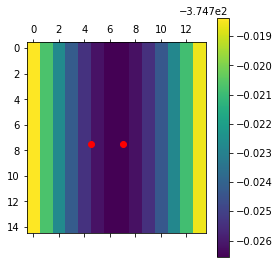

In [115]:
import matplotlib.pyplot as plt
plt.matshow(f)
plt.colorbar()

plt.plot(len(grid1) / 2., len(grid2) / 2., 'ro')
plt.plot(50 * g_opt[ind1] + len(grid1) / 2., 50 * g_opt[ind2] + len(grid2) / 2., 'ro')
print g_opt[ind1]
print g_opt[ind2]

0.701713055851
-0.70174985467


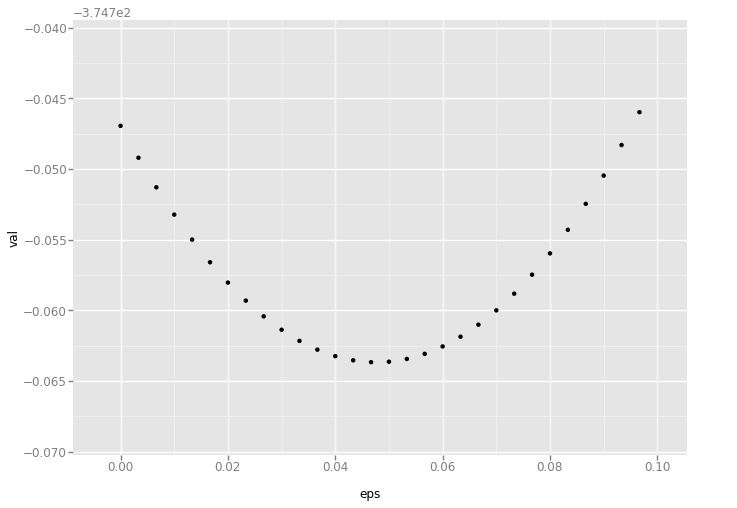

<ggplot: (8784308985069)>


In [71]:

g_opt = KLGrad(x_opt)
x = copy.deepcopy(x_opt) - 0.25 * g_opt

g = KLGrad(x)
print np.linalg.norm(g) ** 2
eps = 1e-6
print (kl_wrapper.Eval(x - eps * g) - kl_wrapper.Eval(x)) / eps


from ggplot import *
import pandas as pd
%matplotlib inline

max_eps = 0.1
eps_vals = np.arange(0., max_eps, max_eps / 30)
kl_steps = [ kl_wrapper.Eval(x - eps * g) for eps in eps_vals ]
plot_df = pd.DataFrame({ 'eps': eps_vals, 'val': kl_steps })
print ggplot(plot_df, aes(x='eps', y='val')) + geom_point()


In [67]:
gnew = KLGrad(x - 0.05 * g)
print np.linalg.norm(g)
print np.linalg.norm(gnew)
print np.linalg.norm(gnew[:27])
print np.linalg.norm(gnew[27:])
print np.linalg.norm(gnew - g)

vp_indices = copy.deepcopy(glmm_par)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))

# print vp_indices

for i in range(len(g)):
    print '%d: %0.4f, %0.4f, %0.4f' % (i, g[i], gnew[i], gnew[i] - g[i])

0.837683147647
0.501939557457
0.500547912466
0.0373511267123
1.01111185038
0: 0.5260, -0.3104, -0.8365
1: -0.0012, 0.0135, 0.0147
2: 0.1737, -0.0088, -0.1824
3: 0.1764, 0.0028, -0.1735
4: 0.1272, -0.0050, -0.1322
5: 0.2059, -0.0049, -0.2108
6: 0.1684, 0.0016, -0.1668
7: 0.0985, -0.0362, -0.1347
8: 0.0961, -0.0193, -0.1154
9: 0.0157, -0.0157, -0.0315
10: 0.0460, -0.0612, -0.1072
11: 0.0147, 0.0203, 0.0057
12: 0.0060, 0.0014, -0.0046
13: 0.1401, -0.0713, -0.2113
14: 0.0275, -0.1197, -0.1471
15: -0.0515, -0.0622, -0.0107
16: -0.1322, -0.0553, 0.0769
17: -0.0648, -0.0926, -0.0278
18: -0.0569, -0.0816, -0.0247
19: -0.0780, -0.1121, -0.0341
20: -0.1383, -0.0595, 0.0788
21: -0.1099, -0.0844, 0.0255
22: -0.1651, -0.1239, 0.0412
23: -0.2490, -0.0673, 0.1817
24: -0.1740, -0.1346, 0.0394
25: -0.1625, -0.1596, 0.0029
26: -0.1328, -0.1397, -0.0069
27: 0.0000, 0.0000, -0.0000
28: 0.0090, -0.0024, -0.0114
29: -0.0000, -0.0000, -0.0000
30: 0.0009, 0.0003, -0.0006
31: 0.0110, -0.0003, -0.0113
32: -0.01

In [ ]:
import time

class OptimizationPath(object):
    def __init__(self):
        self.x_history = []
        pass
    
    def save(self, x):
        self.x_history.append(x)

bfgs_path = OptimizationPath()
init_par_vec = copy.deepcopy(free_par_vec)

# Optimize.
vb_time = time.time()
# print 'Running BFGS'
# vb_opt_bfgs = optimize.minimize(
#     lambda par: kl_wrapper.Eval(par, verbose=True), init_par_vec,
#     method='bfgs', jac=KLGrad, tol=1e-2, callback=bfgs_path.save,
#     options={'maxiter': 100, 'gtol': 1e-2, 'disp': True})

trust_path = OptimizationPath()
print 'Running Newton Trust Region'
# trust_init = copy.deepcopy(vb_opt_bfgs.x)
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.Eval(par, verbose=True),
    trust_init, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd,
    tol=1e-6, callback=trust_path.save,
    options={'maxiter': 100, 'disp': True, 'gtol': 1e-6, 'eta': 0.15 })

vb_time = time.time() - vb_time

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(vb_opt.x)

print 'Done.'

print vb_time / 60

In [ ]:
print len(trust_path.x_history)

# for i in range(len(path.x_history) - 1):
#     print np.sum(path.x_history[i + 1] - path.x_history[i])
    
# for i in range(len(trust_path.x_history)):
#     glmm_par.set_free(trust_path.x_history[i])
#     #print 'Iteration ' + str(i) + '\n'
#     #print str(np.diag(glmm_par['beta'].info.get())) + '\n'
#     #print str(np.diag(glmm_par['mu'].get())) + '\n'
#     #print str(glmm_par['beta'].get()[2]) + '\n'

vals = [ kl_wrapper.Eval(x) for x in trust_path.x_history ]

# for i in range(len(trust_path.x_history)):
    #grad = KLGrad(trust_path.x_history[i])
    #print np.max(np.abs(grad))

# print vals



In [ ]:
hess = KLHess(vb_opt.x)

In [ ]:
vals, vecs = np.linalg.eig(hess)
grad = KLGrad(vb_opt.x)
step_direction = -np.linalg.solve(hess, grad)

In [ ]:
# Get the conjugate gradient step direction

from scipy.sparse.linalg import LinearOperator

ObjHessVecProdLO = LinearOperator((vb_opt.x.size, vb_opt.x.size), lambda par: KLHessVecProd(vb_opt.x, par))
cg_step_direction, info = sp.sparse.linalg.cg(ObjHessVecProdLO, -grad)
assert info == 0
print np.max(np.abs(cg_step_direction - step_direction))


In [ ]:
# Check the random effect estimates.  This requires simulated data.
from ggplot import *
import pandas as pd
%matplotlib inline

# plot_df = pd.DataFrame({ 'iter': np.arange(len(vals)), 'val': np.log10(np.abs(vals)) })
# print ggplot(plot_df[30:], aes(x='iter', y='val')) + geom_point()



In [ ]:
max_eps = 2.
eps_vals = np.arange(0., max_eps, max_eps / 10)
kl_steps = [ kl_wrapper.Eval(vb_opt.x + eps * cg_step_direction) for eps in eps_vals ]
plot_df = pd.DataFrame({ 'eps': eps_vals, 'val': kl_steps })
print ggplot(plot_df, aes(x='eps', y='val')) + geom_point()

print (kl_steps[0] - np.min(kl_steps)) / kl_steps[0]
print kl_steps[0] - np.min(kl_steps)

# glmm_par.set_free(step_direction / np.linalg.norm(step_direction))
# min_vec = vecs[:, vals.argmin()]
# glmm_par.set_free(min_vec)
# print glmm_par

In [ ]:
last_step = trust_path.x_history[len(trust_path.x_history) - 1] - trust_path.x_history[len(trust_path.x_history) - 2]

print np.linalg.norm(cg_step_direction)
print np.linalg.norm(step_direction)
print np.linalg.norm(grad)
print np.linalg.norm(last_step)

plot_df = pd.DataFrame({ 'last_step': last_step, 'step_direction': step_direction })
print ggplot(plot_df, aes(x='step_direction', y='last_step')) + geom_point()

plot_df = pd.DataFrame({ 'cg_step_direction': cg_step_direction, 'step_direction': step_direction })
print ggplot(plot_df, aes(x='step_direction', y='cg_step_direction')) + geom_point()

print np.sum(np.abs(last_step) < 1e-6) / float(len(last_step))
print np.sum(np.abs(step_direction) < 1e-6) / float(len(step_direction))


In [ ]:
# Slow, but probably faster than using CG.
combined_free_par_vec = encode_combined_parameters(glmm_par_opt, prior_par)

hess_time = time.time()
print 'KL Hessian.\n'
kl_hess = KLHess(vb_opt.x)
print 'Log prior Hessian.\n'
log_prior_hess_full = PriorHess(combined_free_par_vec)
hess_time =  time.time() - hess_time
elbo_hess = -kl_hess

print 'hess_time: %f' % hess_time

In [ ]:
glmm_inds = range(glmm_par_opt.free_size())
prior_inds = range(glmm_par_opt.free_size(), len(combined_free_par_vec))
log_prior_hess = log_prior_hess_full[np.ix_(prior_inds, glmm_inds)]

moment_jac = MomentJacobian(vb_opt.x)
lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

vp_indices = copy.deepcopy(glmm_par_opt)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))

In [ ]:
run_name = 'debug'
result_dict = { 'glmm_par_opt': glmm_par_opt.dictval(), 'run_name': run_name,
                'vb_time': vb_time,'hess_time': hess_time, 
                'moment_indices': moment_indices.dictval(),
                'prior_indices': prior_indices.dictval(),
                'vp_indices': vp_indices.dictval(),
                'lrvb_cov': lrvb_cov.tolist(), 'moment_jac': moment_jac.tolist(),
                'elbo_hess': elbo_hess.tolist(), 'log_prior_hess': log_prior_hess.tolist() }

result_json = json.dumps(result_dict)
json_file = open(json_output_filename, 'w')
json_file.write(result_json)
json_file.close()

print(json_output_filename)